# Atrial Fibrillation Project - Modelling (Raw Data)

Student Name: Michael (s2767708) & Pedro da Silva (s2799057)                         
Reg No:  
Group No: 123

## Import Libraries

In [0]:
## for data
import pandas as pd
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import glob
import logging
import numpy as np
import pickle
import sweetviz as sv
import warnings
from tqdm import tqdm
tqdm.pandas()


## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


## for statistical tests
from math import sqrt
import scipy
from scipy.fft import fft, fftfreq
import statistics
from statistics import mean
import statsmodels.api as sm
import statsmodels.formula.api as smf


## for machine learning
import hrvanalysis
from hrvanalysis import get_csi_cvi_features, get_frequency_domain_features, get_geometrical_features, get_poincare_plot_features, get_sampen, get_time_domain_features

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from scikeras.wrappers import KerasRegressor, KerasClassifier

from scipy.stats import kstest, shapiro

from sklearn import datasets, decomposition, ensemble, feature_selection, linear_model, metrics, model_selection, preprocessing, svm, tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.exceptions import DataConversionWarning
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, explained_variance_score, f1_score, mean_absolute_error, mean_squared_error, precision_score, r2_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, GridSearchCV, ShuffleSplit, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.tree import DecisionTreeClassifier

from statsmodels.api import Logit
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import acorr_ljungbox, het_white
from statsmodels.tools.tools import add_constant

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from tslearn.neighbors import KNeighborsTimeSeriesClassifier

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

print('Imported all libraries successfully.')

Imported all libraries successfully.


In [0]:
# Suppress the warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('absl').setLevel(logging.ERROR)
logging.getLogger('sklearn').setLevel(logging.ERROR)

In [0]:
import os
current_path = os.getcwd()
print(current_path)

/databricks/driver


## Import Dataset

In [0]:
# Read the dataset
raw_df = pd.read_parquet(r'/dbfs/FileStore/tables/Michael/AF/af_df_featureImp_200.parquet')
print(raw_df.shape)
raw_df.head(10)

(1049993, 11)


,std_hr,max_hr,median_nni,triangular_index,pnni_20,cvnni,range_nni,af,hf,lf_hf_ratio,vlf
0,6.430783,112.149533,780.0,3.750000,3.448276,0.060063,265,0,24.396620,2.918488,34.959704
1,0.584538,77.419355,790.0,1.875000,0.000000,0.007797,25,0,11.057630,0.252836,2.853465
2,0.781545,77.419355,790.0,2.142857,0.000000,0.010512,35,0,19.919897,0.938439,11.392116
3,0.844818,77.419355,792.5,2.500000,0.000000,0.011329,35,0,29.719194,0.556774,10.752915
4,1.027328,77.922078,782.5,3.750000,0.000000,0.013715,35,0,9.453751,4.409898,11.581953
5,0.681879,78.431373,775.0,2.727273,0.000000,0.009041,30,0,8.631484,0.636497,6.303364
6,1.035273,78.431373,787.5,3.750000,0.000000,0.013798,40,0,19.423675,1.932566,31.672650
7,0.860270,77.922078,790.0,3.000000,0.000000,0.011494,35,0,5.257853,2.071387,3.789156
8,0.701275,77.922078,785.0,2.307692,0.000000,0.009343,30,0,28.606596,0.666281,2.423699
9,1.021052,79.470199,785.0,2.727273,0.000000,0.013469,45,0,15.022013,3.393326,9.267269


## Modelling with the Pre-Processed Dataset (SMOTE)

### Split the dataset into train and test

In [0]:
y_cols = ['af']
X_cols = [col for col in raw_df.columns if col not in y_cols]

In [0]:
# Instantiate the SMOTE
sm = SMOTE(random_state=123)

# Fit and transform the data
X_smote, y_smote = sm.fit_resample(raw_df[X_cols], raw_df[y_cols])

In [0]:
smote_counts = pd.DataFrame({'Control': y_smote.values.flatten(), 'Count': np.ones(len(y_smote.values))}) \
                          .groupby('Control').count().reset_index()

fig = px.bar(smote_counts, x='Control', y='Count', color='Control', 
             color_discrete_map={0:'#0000FF', 1:'#F89406'}, text='Count')

fig.update_traces(texttemplate='%{text}', textposition='outside', marker_coloraxis=None)
fig.update_layout(xaxis_title='Cases (0=Not AF, 1=AF)', yaxis_title='Count',
                  title='Atrial Fibrillation Case Counts', showlegend=False,
                  width=300, height=500, xaxis={'type': 'category'},
                  template="plotly_dark")
fig.show()

In [0]:
# split train test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 123)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### MODEL 1: Logistic Regression

In [0]:
# GridSearch to determine the best parameters
parameters = {
  'C': [0.01, 0.1, 1.0, 2.0, 10.0]
}

# Create the Classifier
model_logreg = LogisticRegression()

# Create the GridSearch object
grid_search = GridSearchCV(
    estimator = model_logreg,
    param_grid = parameters,
    scoring = 'recall',
    cv = 5
)

# Fit the GridSearch into the dataset
grid_search = grid_search.fit(X_train, y_train)

# Determine the best parameters and score
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Recall: {:.2f}".format(best_score))
print("Best Parameters:", best_parameters)

Best Recall: 0.84
Best Parameters: {'C': 2.0}


In [0]:
# Create the model with best param
model_logreg = LogisticRegression(C=best_parameters['C'])

## K-fold validation on Training dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model_logreg.fit(X_train[train],y_train[train]).predict(X_train[test])
    true = y_train[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Training dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Training dataset:

Accuracy: 0.89
Precision: 0.94
Recall: 0.84
F1: 0.89


In [0]:
## K-fold validation on Test dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_test, y_test):
    prediction = model_logreg.fit(X_test[train],y_test[train]).predict(X_test[test])
    true = y_test[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Test dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Test dataset:

Accuracy: 0.89
Precision: 0.94
Recall: 0.84
F1: 0.89


### MODEL 2: ElasticNet Regression (L1 Lasso & L2 Ridge)

In [0]:
# GridSearch to determine the best parameters
parameters = {'C': [0.01, 0.1, 1.0, 2.0, 10.0],
              'l1_ratio': [0.1, 0.25, 0.5, 0.75, 1.0]}

# Create the Classifier
model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000)

# Create the GridSearch object
grid_search = model_selection.GridSearchCV(estimator = model,
                                           param_grid = parameters,
                                           scoring = 'recall',
                                           cv = 5)

# Fit the GridSearch into the d ataset
grid_search = grid_search.fit(X_train, y_train)

# Determine the best parameters and score
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Recall: {:.2f}".format(best_score))
print("Best Parameters:", best_parameters)

Best Recall: 0.84
Best Parameters: {'C': 10.0, 'l1_ratio': 1.0}


In [0]:
# Create the model with best param
model_elasticnet = LogisticRegression(
    C=best_parameters['C'],
    l1_ratio=best_parameters['l1_ratio'],
    penalty='elasticnet', solver='saga', max_iter=1000
)

## K-fold validation on Training dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model_elasticnet.fit(X_train[train],y_train[train]).predict(X_train[test])
    true = y_train[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Training dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Training dataset:

Accuracy: 0.89
Precision: 0.94
Recall: 0.84
F1: 0.89


In [0]:
## K-fold validation on Test dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_test, y_test):
    prediction = model_elasticnet.fit(X_test[train],y_test[train]).predict(X_test[test])
    true = y_test[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Test dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Test dataset:

Accuracy: 0.89
Precision: 0.94
Recall: 0.84
F1: 0.89


### MODEL 3: K-Nearest Neighbors DTW

In [0]:
# GridSearch to determine the best parameters
parameters = {
    'n_neighbors': [3, 5, 7]
}

# Create the Classifier
model_knnDtw = KNeighborsTimeSeriesClassifier(metric='dtw')

# Create the GridSearch object
grid_search = GridSearchCV(estimator = model_knnDtw,
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5)

# Fit the GridSearch into the dataset
grid_search = grid_search.fit(X_train[:1000:], y_train[:1000:])

# Determine the best parameters and score
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Recall: {:.2f}".format(best_score))
print("Best Parameters:", best_parameters)

Best Recall: 0.88
Best Parameters: {'n_neighbors': 3}


In [0]:
# Create the model with best param
model_knn = KNeighborsTimeSeriesClassifier(
    n_neighbors=best_parameters['n_neighbors'],
    metric='dtw'
)

## K-fold validation on Training dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_train[:1000:], y_train[:1000:]):
    prediction = model_knn.fit(X_train[:1000:][train],y_train[:1000:][train]).predict(X_train[:1000:][test])
    true = y_train[:1000:][test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Training dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Training dataset:

Accuracy: 0.89
Precision: 0.88
Recall: 0.88
F1: 0.88


In [0]:
## K-fold validation on Test dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_test[:1000:], y_test[:1000:]):
    prediction = model_knn.fit(X_test[:1000:][train],y_test[:1000:][train]).predict(X_test[:1000:][test])
    true = y_test[:1000:][test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Test dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Test dataset:

Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1: 0.91


### MODEL 4: Naive Bayes

In [0]:
# Create the model with best param
model_nb = GaussianNB()

## K-fold validation on Training dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model_nb.fit(X_train[train],y_train[train]).predict(X_train[test])
    true = y_train[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Training dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Training dataset:

Accuracy: 0.89
Precision: 0.94
Recall: 0.83
F1: 0.88


In [0]:
## K-fold validation on Test dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_test, y_test):
    prediction = model_nb.fit(X_test[train],y_test[train]).predict(X_test[test])
    true = y_test[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Test dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Test dataset:

Accuracy: 0.89
Precision: 0.94
Recall: 0.83
F1: 0.88


### MODEL 5: Decision Tree

In [0]:
# GridSearch to determine the best parameters
parameters = {
    'max_depth': [3, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

# Create the Classifier
model_dtree = DecisionTreeClassifier()

# Create the GridSearch object
grid_search = GridSearchCV(estimator = model_dtree,
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5)

# Fit the GridSearch into the dataset
grid_search = grid_search.fit(X_train, y_train)

# Determine the best parameters and score
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Recall: {:.2f}".format(best_score))
print("Best Parameters:", best_parameters)

Best Recall: 0.90
Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt'}


In [0]:
# Create the model with best param
model_dtree = DecisionTreeClassifier(
    max_depth=best_parameters['max_depth'],
    criterion=best_parameters['criterion'],
    max_features=best_parameters['max_features']
)

## K-fold validation on Training dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model_dtree.fit(X_train[train],y_train[train]).predict(X_train[test])
    true = y_train[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Training dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Training dataset:

Accuracy: 0.92
Precision: 0.95
Recall: 0.89
F1: 0.92


In [0]:
## K-fold validation on Test dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_test, y_test):
    prediction = model_dtree.fit(X_test[train],y_test[train]).predict(X_test[test])
    true = y_test[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Test dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Test dataset:

Accuracy: 0.92
Precision: 0.96
Recall: 0.88
F1: 0.92


### MODEL 6: Random Forest

In [0]:
# GridSearch to determine the best parameters
parameters = {'n_estimators': [50,100,150,300],
              'max_depth': [3,5,7,9],
              'min_samples_split': [3,5,7],
              'max_features': ['sqrt','log2']}

# Create the Classifier
model_rf = RandomForestClassifier()

# Create the GridSearch object
grid_search = GridSearchCV(estimator = model_rf,
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5)

# Fit the GridSearch into the dataset
grid_search = grid_search.fit(X_train, y_train)

# Determine the best parameters and score
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Recall: {:.2f}".format(best_score))
print("Best Parameters:", best_parameters)

In [0]:
# Create the model with best param
model_rf = RandomForestClassifier(
    n_estimators=best_parameters['n_estimators'],
    max_depth=best_parameters['max_depth'],
    min_samples_split=best_parameters['min_samples_split'],
    max_features=best_parameters['max_features']
)

## K-fold validation on Training dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model_rf.fit(X_train[train],y_train[train]).predict(X_train[test])
    true = y_train[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Training dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Training dataset:

Accuracy: 0.93
Precision: 0.96
Recall: 0.89
F1: 0.93


In [0]:
## K-fold validation on Test dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_test, y_test):
    prediction = model_rf.fit(X_test[train],y_test[train]).predict(X_test[test])
    true = y_test[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Test dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

Model metrics on Test dataset:

Accuracy: 0.93
Precision: 0.96
Recall: 0.90
F1: 0.93


### Model 7: XGBoost

In [0]:
# Define the parameter search space
parameters = {
    'n_estimators': [100,300,500,700,900],
    'max_depth': [3,5,7,9],
    'learning_rate': [0.01,0.1,1.0]
}

# Create the Classifier
model_xgb = XGBClassifier()

# Create the GridSearch object
grid_search = GridSearchCV(estimator = model_xgb,
                           param_grid = parameters,
                           scoring = 'recall',
                           cv = 5)

# Fit the GridSearch into the dataset
grid_search = grid_search.fit(X_train, y_train)

# Determine the best parameters and score
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Recall: {:.2f}".format(best_score))
print("Best Parameters:", best_parameters)

Best Recall: 0.95
Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 900}


Model metrics on Training dataset:

Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1: 0.99


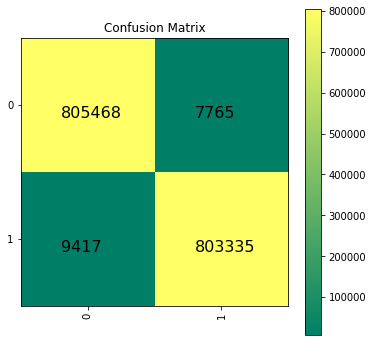

In [0]:
# Create the model with best param
model_xgb = XGBClassifier(
    n_estimators=best_parameters['n_estimators'],
    max_depth=best_parameters['max_depth'],
    learning_rate=best_parameters['learning_rate']
)

## K-fold validation on Training dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []
conf_mat = None

cv = model_selection.KFold(n_splits=5, shuffle=True)

for train, test in cv.split(X_train, y_train):
    prediction = model_xgb.fit(X_train[train],y_train[train]).predict(X_train[test])
    true = y_train[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

    # Constructing the confusion matrix
    if conf_mat is None:
        conf_mat = confusion_matrix(true, prediction, labels=[0, 1])
    else:
        conf_mat += confusion_matrix(true, prediction, labels=[0, 1])

print('Model metrics on Training dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)

cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(2), [0, 1], rotation=90)
_ = plt.yticks(range(2), [0, 1])

Model metrics on Test dataset:

Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1: 0.99


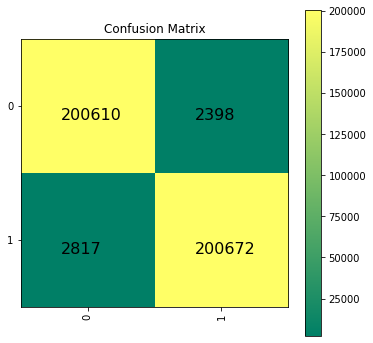

In [0]:
## K-fold validation on Test dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []
conf_mat = None

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_test, y_test):
    prediction = model_xgb.fit(X_test[train],y_test[train]).predict(X_test[test])
    true = y_test[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))
    
    # Constructing the confusion matrix
    if conf_mat is None:
        conf_mat = confusion_matrix(true, prediction, labels=[0, 1])
    else:
        conf_mat += confusion_matrix(true, prediction, labels=[0, 1])

print('Model metrics on Test dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)

cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(2), [0, 1], rotation=90)
_ = plt.yticks(range(2), [0, 1])

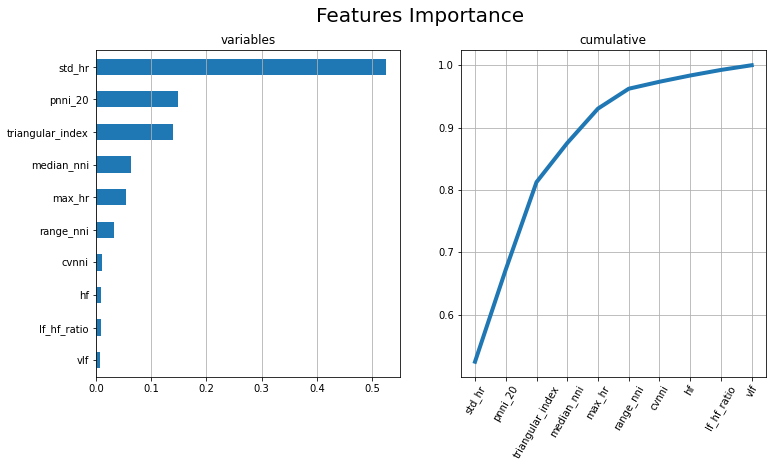

In [0]:
# Feature importance
importances = model_xgb.feature_importances_

## Put in a pandas dtf
df_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":X_cols}).sort_values("IMPORTANCE", ascending=False)
df_importances['cumsum'] = df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12,6))
fig.suptitle("Features Importance", fontsize=20)

# First graph: variables
ax[0].title.set_text('variables')
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0])
ax[0].set(ylabel="")
ax[0].grid(axis='x')

# Second graph: cumulative
ax[1].title.set_text('cumulative')
df_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)), xticklabels=df_importances.index)
plt.xticks(rotation=60)
ax[1].grid(axis='both')

plt.show()

### MODEL 8: Artificial Neural Network

In [0]:
model_ann = tf.keras.models.Sequential() # Initialize ANN
model_ann.add(tf.keras.layers.Dense(units=4, activation='relu')) # Add input layer & the first hidden layers
model_ann.add(tf.keras.layers.Dense(units=4, activation='relu')) # Add the second hidden layers
model_ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # Add output layer
model_ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['Recall']) # compile the ANN

In [0]:
model_ann.fit(X_train, y_train, batch_size = 100, epochs = 30)

Epoch 1/30
 5715/16260 [=========>....................] - ETA: 13s - loss: 0.2731 - recall: 0.8250       

*** WARNING: max output size exceeded, skipping output. ***

1/1 [==============================] - 0s 82ms/step
Out[15]: <keras.callbacks.History at 0x7f40da06ad30>

In [0]:
## K-fold validation on Training dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model_ann.predict(X_train[test])
    prediction = (prediction > 0.5)
    true = y_train[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Training dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

 2566/10163 [======>.......................] - ETA: 6s

*** WARNING: max output size exceeded, skipping output. ***

10163/10163 [==============================] - 9s 891us/step
Model metrics on Training dataset:

Accuracy: 0.91
Precision: 0.95
Recall: 0.87
F1: 0.91


In [0]:
## K-fold validation on Test dataset
accuracy_kf = []
precision_kf = []
recall_kf = []
f1_kf = []

cv = model_selection.KFold(n_splits=5, shuffle=True)

i = 1
for train, test in cv.split(X_test, y_test):
    prediction = model_ann.predict(X_test[test])
    prediction = (prediction > 0.5)
    true = y_test[test]
    accuracy_kf.append(accuracy_score(true, prediction))
    precision_kf.append(precision_score(true, prediction))
    recall_kf.append(recall_score(true, prediction))
    f1_kf.append(f1_score(true, prediction))

print('Model metrics on Test dataset:\n')
print('Accuracy: %0.2f' % mean(accuracy_kf))
print('Precision: %0.2f' % mean(precision_kf))
print('Recall: %0.2f' % mean(recall_kf))
print('F1: %0.2f' % mean(f1_kf))

2541/2541 [==============================] - 2s 878us/step
Model metrics on Test dataset:

Accuracy: 0.91
Precision: 0.95
Recall: 0.86
F1: 0.91
